In [43]:
# ==== setup & config ====
from __future__ import annotations
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, Tuple
import re
import numpy as np
import pandas as pd


# -------- configuration knobs --------
@dataclass
class PipelineConfig:
    # filtering
    start_date: Optional[pd.Timestamp] = None   # inclusive
    end_date:   Optional[pd.Timestamp] = None   # inclusive
    include_exhibitions: bool = False
    include_cancellations: bool = False

    # date-range semantics:
    # "fresh": reset cumulative at start_date (baseline=0)
    # "carry": carry all-time baseline up to (start_date - 1 day)
    range_mode: str = "fresh"   # "fresh" | "carry"

    # output
    out_dir: Path = Path("../data/tables")
    write_parquet: bool = False  # needs pyarrow/fastparquet
    write_csv: bool = True

    # misc
    verbose: bool = True


# -------- column resolution --------
@dataclass
class ColumnMap:
    Date: str
    Season_Year: Optional[str]
    Game_ID: Optional[str]
    Home_Team: str
    Away_Team: str
    Home_Score: str
    Away_Score: str
    OT: Optional[str]
    Game_Notes: Optional[str]
    Home_Team_Link: Optional[str]
    Away_Team_Link: Optional[str]
    Conference: Optional[str]

def _find_col(possible, cols) -> Optional[str]:
    norm = {c.lower().replace(" ", "_"): c for c in cols}
    for p in possible:
        k = p.lower().replace(" ", "_")
        if k in norm:
            return norm[k]
    return None

def resolve_columns(df: pd.DataFrame) -> ColumnMap:
    cols = df.columns.tolist()
    cm = ColumnMap(
        Date=_find_col(["Date"], cols) or "Date",
        Season_Year=_find_col(["Season_Year","Season","Season Year"], cols),
        Game_ID=_find_col(["Game_ID","GameID","Game Id","gid"], cols),
        Home_Team=_find_col(["Home_Team","Home Team","Home"], cols) or "Home_Team",
        Away_Team=_find_col(["Away_Team","Away Team","Away","Visitor_Team","Visitor Team"], cols) or "Away_Team",
        Home_Score=_find_col(["Home_Score","Home Score","HomeGoals","Home_Goals"], cols) or "Home_Score",
        Away_Score=_find_col(["Away_Score","Away Score","AwayGoals","Away_Goals"], cols) or "Away_Score",
        OT=_find_col(["OT","OT_SO","OT/SO","Overtime","Shootout"], cols),
        Game_Notes=_find_col(["Game_Notes","Notes","Game Notes"], cols),
        Home_Team_Link=_find_col(["Home_Team_Link","Home Team Link","Home_Link"], cols),
        Away_Team_Link=_find_col(["Away_Team_Link","Away Team Link","Away_Link"], cols),
        Conference=_find_col(["Conference"], cols),
    )
    # light validation
    required = [cm.Date, cm.Home_Team, cm.Away_Team, cm.Home_Score, cm.Away_Score]
    if any(r is None for r in required):
        missing = [n for n, v in zip(
            ["Date","Home_Team","Away_Team","Home_Score","Away_Score"], required) if v is None]
        raise ValueError(f"Missing required columns: {missing}")
    return cm


# -------- helpers --------
TEAM_ID_REGEX = re.compile(r"/reports/team/.+?/(\d+)")

def extract_team_id(url_like) -> Optional[int]:
    if pd.isna(url_like): return pd.NA
    m = TEAM_ID_REGEX.search(str(url_like))
    return int(m.group(1)) if m else pd.NA

def stable_team_hash(name: str) -> int:
    # deterministic-ish 9-digit id from name (lower/stripped)
    key = str(name).strip().lower()
    return abs(hash(key)) % (10**9)


def make_compressed_x(dates: pd.Series, max_gap_days: int = 21, keep_gap_days: int = 3) -> np.ndarray:
    """
    Map real dates -> 'compressed time' where long gaps are squished.
    Any gap > max_gap_days is reduced to keep_gap_days.
    Returns a monotonic x array you can plot against.
    """
    d = pd.to_datetime(dates).values.astype("datetime64[D]").astype(int)
    deltas = np.diff(d)
    # clamp each gap
    clamped = np.minimum(deltas, max_gap_days)
    # subtract the amount we want to remove, leaving keep_gap_days for long gaps
    squeeze = np.maximum(clamped - keep_gap_days, 0)
    # effective step per interval
    steps = deltas - squeeze
    x = np.concatenate([[0], np.cumsum(steps)])
    return x


## Load & Normalize
reads CSV, coerces types, normalizes text, extracts team IDs (or hashes), and ensures Game_ID/Season_Year exist

In [44]:
# ==== load & normalize ====
def load_and_normalize(csv_path: Path) -> Tuple[pd.DataFrame, ColumnMap]:
    df = pd.read_csv(csv_path)
    cm = resolve_columns(df)

    # parse/normalize
    df[cm.Date] = pd.to_datetime(df[cm.Date], errors="coerce")
    for sc in [cm.Home_Score, cm.Away_Score]:
        df[sc] = pd.to_numeric(df[sc], errors="coerce").astype("Int64")
    if cm.OT:
        df[cm.OT] = df[cm.OT].astype(str).str.lower().replace({"nan": ""})
    if cm.Game_Notes:
        df[cm.Game_Notes] = df[cm.Game_Notes].astype(str).str.lower()

    # IDs
    if cm.Home_Team_Link and cm.Away_Team_Link:
        df["Home_Team_ID"] = df[cm.Home_Team_Link].apply(extract_team_id)
        df["Away_Team_ID"] = df[cm.Away_Team_Link].apply(extract_team_id)
    else:
        df["Home_Team_ID"] = df[cm.Home_Team].map(stable_team_hash)
        df["Away_Team_ID"] = df[cm.Away_Team].map(stable_team_hash)

    # Season/year fallback
    if cm.Season_Year is None:
        cm.Season_Year = "__Season_Fallback__"
        df[cm.Season_Year] = df[cm.Date].dt.year

    # Game ID fallback
    if cm.Game_ID is None:
        cm.Game_ID = "__GameID_Fallback__"
        df[cm.Game_ID] = np.arange(1, len(df) + 1)

    # drop rows with bad/missing date
    df = df[df[cm.Date].notna()].copy()

    return df, cm


## Filter Games (date range, exhibitions/cancellations, scores)
trims to relevant rows, with clear switches for exhibitions/cancellations and date range.

In [45]:
# ==== filter games ====
def filter_games(df: pd.DataFrame, cm: ColumnMap, cfg: PipelineConfig) -> pd.DataFrame:
    out = df.copy()

    # team IDs must exist
    out = out[out["Home_Team_ID"].notna() & out["Away_Team_ID"].notna()]

    # scores must exist to compute outcomes/GD
    out = out[out[cm.Home_Score].notna() & out[cm.Away_Score].notna()]

    # exhibitions/cancellations
    if cm.Game_Notes:
        if not cfg.include_exhibitions:
            out = out[~out[cm.Game_Notes].str.contains("exhib", na=False)]
        if not cfg.include_cancellations:
            out = out[~out[cm.Game_Notes].str.contains("cancel", na=False)]

    # date range
    if cfg.start_date is not None:
        out = out[out[cm.Date] >= pd.Timestamp(cfg.start_date)]
    if cfg.end_date is not None:
        out = out[out[cm.Date] <= pd.Timestamp(cfg.end_date)]

    return out


## Explode to Long (one row per team per game)
 turns each game into two rows (home/away) with a common schema

* Future tweaks: carry a neutral “site” indicator for tournaments/neutral-site games if you want H/A/N splits.



In [46]:
# ==== explode to long ====
def explode_to_long(df: pd.DataFrame, cm: ColumnMap) -> pd.DataFrame:
    home = df.rename(columns={
        cm.Date: "Date", cm.Season_Year: "Season_Year", cm.Game_ID: "Game_ID",
        cm.Home_Team: "team", "Home_Team_ID": "team_id", cm.Home_Score: "team_score",
        cm.Away_Team: "opp",  "Away_Team_ID": "opp_id",  cm.Away_Score: "opp_score",
        **({cm.OT: "OT"} if cm.OT else {}), **({cm.Game_Notes: "Game_Notes"} if cm.Game_Notes else {}),
        **({cm.Conference: "Conference"} if cm.Conference else {}),
    })
    home = home[["Date","Season_Year","Game_ID","team","team_id","team_score","opp","opp_id","opp_score"]
                + (["OT"] if cm.OT else []) + (["Game_Notes"] if cm.Game_Notes else [])
                + (["Conference"] if cm.Conference else [])]
    home["venue"] = "H"

    away = df.rename(columns={
        cm.Date: "Date", cm.Season_Year: "Season_Year", cm.Game_ID: "Game_ID",
        cm.Away_Team: "team", "Away_Team_ID": "team_id", cm.Away_Score: "team_score",
        cm.Home_Team: "opp",  "Home_Team_ID": "opp_id",  cm.Home_Score: "opp_score",
        **({cm.OT: "OT"} if cm.OT else {}), **({cm.Game_Notes: "Game_Notes"} if cm.Game_Notes else {}),
        **({cm.Conference: "Conference"} if cm.Conference else {}),
    })
    away = away[["Date","Season_Year","Game_ID","team","team_id","team_score","opp","opp_id","opp_score"]
                + (["OT"] if cm.OT else []) + (["Game_Notes"] if cm.Game_Notes else [])
                + (["Conference"] if cm.Conference else [])]
    away["venue"] = "A"

    long = pd.concat([home, away], ignore_index=True)
    return long


## Outcomes & Goal Differential
W/L/T flags, .500 increment (delta), per-game GD.

In [47]:
# ==== outcomes & gd ====
def compute_outcomes_and_gd(long: pd.DataFrame) -> pd.DataFrame:
    out = long.copy()

    # robust comparisons on nullable Int64
    out["result"]  = np.where(out["team_score"].gt(out["opp_score"]), "W",
                       np.where(out["team_score"].lt(out["opp_score"]), "L", "T"))
    out["is_win"]  = (out["result"] == "W").astype(int)
    out["is_loss"] = (out["result"] == "L").astype(int)
    out["is_tie"]  = (out["result"] == "T").astype(int)

    # .500 increment (ties neutral)
    out["delta"]   = out["is_win"] - out["is_loss"]

    # per-game goal differential (reg/OT only; SO should not add goals)
    out["gd"] = (out["team_score"].astype("int64") - out["opp_score"].astype("int64"))

    return out


## Cumulative Stats (+ optional carry-forward baseline)
sorts rows and computes cumulative W/L/T, games-above-.500, and cumulative GD.
supports both “fresh” and “carry” range semantics.

In [48]:
def compute_cumulatives(
    long_with_outcomes: pd.DataFrame,
    baseline: Optional[pd.DataFrame] = None  # per-team starting values
) -> pd.DataFrame:
    out = long_with_outcomes.sort_values(["team_id","Date","Game_ID"], kind="mergesort").copy()
    out["gp"] = out.groupby("team_id").cumcount() + 1

    # base cumulatives (fresh)
    out["cum_w"]  = out.groupby("team_id")["is_win"].cumsum()
    out["cum_l"]  = out.groupby("team_id")["is_loss"].cumsum()
    out["cum_t"]  = out.groupby("team_id")["is_tie"].cumsum()
    out["cum_gd"] = out.groupby("team_id")["gd"].cumsum()
    out["games_above_500"] = out["cum_w"] - out["cum_l"]
    out["record_str"] = (
        out["cum_w"].astype(int).astype(str) + "-" +
        out["cum_l"].astype(int).astype(str) + "-" +
        out["cum_t"].astype(int).astype(str)
    )

    # carry-forward baseline (optional)
    if baseline is not None and not baseline.empty:
        b = baseline.set_index("team_id")

        # align per-row baselines to out['team_id']; fill missing with 0
        w0 = b["cum_w"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        l0 = b["cum_l"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        t0 = b["cum_t"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")
        gd0= b["cum_gd"].reindex(out["team_id"]).fillna(0).to_numpy(dtype="int64")

        # add carried baselines
        out["cum_w"]  = out["cum_w"].to_numpy(dtype="int64")  + w0
        out["cum_l"]  = out["cum_l"].to_numpy(dtype="int64")  + l0
        out["cum_t"]  = out["cum_t"].to_numpy(dtype="int64")  + t0
        out["cum_gd"] = out["cum_gd"].to_numpy(dtype="int64") + gd0

        # recompute derived columns with carries applied
        out["games_above_500"] = out["cum_w"] - out["cum_l"]
        out["record_str"] = (
            out["cum_w"].astype(int).astype(str) + "-" +
            out["cum_l"].astype(int).astype(str) + "-" +
            out["cum_t"].astype(int).astype(str)
        )

    return out


## Baseline Builder (for range_mode="carry")
computes per-team totals before the analysis window.
lets you show true all-time cumulative values within a date slice.

In [49]:
# ==== baseline (pre-start carry) ====
def make_baseline(long_full: pd.DataFrame, start_date: Optional[pd.Timestamp]) -> pd.DataFrame:
    if start_date is None:
        return pd.DataFrame(columns=["team_id","cum_w","cum_l","cum_t","cum_gd"])
    pre = long_full[long_full["Date"] < pd.Timestamp(start_date)].copy()
    if pre.empty:
        return pd.DataFrame(columns=["team_id","cum_w","cum_l","cum_t","cum_gd"])
    agg = pre.groupby("team_id").agg(
        cum_w=("is_win","sum"),
        cum_l=("is_loss","sum"),
        cum_t=("is_tie","sum"),
        cum_gd=("gd","sum"),
    ).reset_index()
    return agg


## Timeline (tidy output) & Summary (annotations)
selects plot-ready columns and computes summary stats incl. GD milestones.

In [50]:
# ==== timeline & summary ====
def make_timeline(long_cum: pd.DataFrame) -> pd.DataFrame:
    cols = ["team_id","team","Date","Game_ID","Season_Year","gp",
            "team_score","opp_score","result","delta","gd","cum_gd",
            "cum_w","cum_l","cum_t","games_above_500","venue"]
    # keep only what exists (Conference/OT may not be present)
    cols = [c for c in cols if c in long_cum.columns]
    return long_cum[cols].copy()

def make_summary(timeline: pd.DataFrame) -> pd.DataFrame:
    def _summ(g: pd.DataFrame) -> pd.Series:
        g = g.sort_values("Date")
        # guard idxmax/min on empty
        max500 = g["games_above_500"].idxmax()
        min500 = g["games_above_500"].idxmin()
        maxgd  = g["cum_gd"].idxmax()
        mingd  = g["cum_gd"].idxmin()

        at500 = g[g["games_above_500"] == 0]
        out = {
            "team": g["team"].iloc[0],
            "first_date": g["Date"].min(),
            "last_date": g["Date"].max(),
            "max_point": g.loc[max500, "games_above_500"],
            "max_date":  g.loc[max500, "Date"],
            "min_point": g.loc[min500, "games_above_500"],
            "min_date":  g.loc[min500, "Date"],
            "final_w":   g["cum_w"].iloc[-1],
            "final_l":   g["cum_l"].iloc[-1],
            "final_t":   g["cum_t"].iloc[-1],
            "last_500_date": at500["Date"].iloc[-1] if not at500.empty else pd.NaT,
            # GD milestones
            "max_cum_gd": g.loc[maxgd, "cum_gd"],
            "max_cum_gd_date": g.loc[maxgd, "Date"],
            "min_cum_gd": g.loc[mingd, "cum_gd"],
            "min_cum_gd_date": g.loc[mingd, "Date"],
            "final_cum_gd": g["cum_gd"].iloc[-1],
        }
        return pd.Series(out)

    return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


## Save Outputs
writes CSV (and optionally Parquet) + a tiny completion message

In [51]:
# ==== save outputs ====
def save_outputs(timeline: pd.DataFrame, summary: pd.DataFrame, cfg: PipelineConfig) -> Dict[str, Path]:
    cfg.out_dir.mkdir(parents=True, exist_ok=True)
    paths = {}
    if cfg.write_csv:
        paths["timeline_csv"] = cfg.out_dir / "team_timeseries.csv"
        paths["summary_csv"]  = cfg.out_dir / "team_summary.csv"
        timeline.to_csv(paths["timeline_csv"], index=False)
        summary.to_csv(paths["summary_csv"], index=False)
    if cfg.write_parquet:
        paths["timeline_parquet"] = cfg.out_dir / "team_timeseries.parquet"
        paths["summary_parquet"]  = cfg.out_dir / "team_summary.parquet"
        timeline.to_parquet(paths["timeline_parquet"], index=False)
        summary.to_parquet(paths["summary_parquet"], index=False)

    if cfg.verbose:
        print("Saved:")
        for k, p in paths.items():
            print(f" - {k}: {p}")
        print(f"timeline shape: {timeline.shape} | summary shape: {summary.shape}")
    return paths


## RUN

In [52]:
# ==== run pipeline ====
def run_pipeline(input_csv: Path, cfg: PipelineConfig) -> Dict[str, Path]:
    # 1) load full dataset & normalize
    df, cm = load_and_normalize(input_csv)

    # 2) (always) explode full to long + outcomes/GD (so baseline can be computed)
    df_full = filter_games(df, cm, PipelineConfig(
        start_date=None, end_date=None,
        include_exhibitions=cfg.include_exhibitions,
        include_cancellations=cfg.include_cancellations,
        range_mode="fresh", out_dir=cfg.out_dir, verbose=False
    ))
    long_full = explode_to_long(df_full, cm)
    long_full = compute_outcomes_and_gd(long_full)

    # 3) slice analysis window
    df_slice = filter_games(df, cm, cfg)  # applies date range if set
    long_slice = explode_to_long(df_slice, cm)
    long_slice = compute_outcomes_and_gd(long_slice)

    # 4) optional baseline
    baseline = None
    if cfg.range_mode.lower() == "carry" and cfg.start_date is not None:
        baseline = make_baseline(long_full, cfg.start_date)

    # 5) cumulatives, timeline, summary, save
    long_cum = compute_cumulatives(long_slice, baseline=baseline)
    timeline = make_timeline(long_cum)
    summary  = make_summary(timeline)
    return save_outputs(timeline, summary, cfg)


In [53]:
# All-time (fresh baseline), CSV outputs to ../data/tables
cfg = PipelineConfig(
    start_date=None,
    end_date=None,
    range_mode="fresh",
    out_dir=Path("../data/tables"),
    write_csv=True, write_parquet=False,
    verbose=True
)
run_pipeline(Path("../data/tables/results_all_time.csv"), cfg)

# 1990–present with carry-forward baseline (true all-time values within slice)
cfg_90s = PipelineConfig(
    start_date=pd.Timestamp("1990-01-01"),
    end_date=None,
    range_mode="carry",
    out_dir=Path("../data/tables/1990_plus"),
    write_csv=True, write_parquet=False,
)
run_pipeline(Path("../data/tables/results_all_time.csv"), cfg_90s)


C:\Users\jbanc\AppData\Local\Temp\ipykernel_16184\17810211.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


Saved:
 - timeline_csv: ..\data\tables\team_timeseries.csv
 - summary_csv: ..\data\tables\team_summary.csv
timeline shape: (96548, 17) | summary shape: (66, 17)


C:\Users\jbanc\AppData\Local\Temp\ipykernel_16184\17810211.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return (timeline.groupby("team_id", group_keys=False).apply(_summ).reset_index())


Saved:
 - timeline_csv: ..\data\tables\1990_plus\team_timeseries.csv
 - summary_csv: ..\data\tables\1990_plus\team_summary.csv
timeline shape: (70620, 17) | summary shape: (66, 17)


{'timeline_csv': WindowsPath('../data/tables/1990_plus/team_timeseries.csv'),
 'summary_csv': WindowsPath('../data/tables/1990_plus/team_summary.csv')}

# Vizualizations

## Matplot Lib Single Team Plot
- over/under .500, goal differential or both

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from typing import Optional, Tuple, List, Union, Dict

# ---------- small helpers ----------

def _select_team(timeline: pd.DataFrame, team: Union[str, int]) -> pd.DataFrame:
    """Return a sorted copy of the team rows by team name (casefold) or team_id (int)."""
    if isinstance(team, (int, np.integer)):
        g = timeline.loc[timeline["team_id"] == int(team)].copy()
    else:
        g = timeline.loc[timeline["team"].str.casefold() == str(team).casefold()].copy()
    if g.empty:
        raise ValueError(f"No rows for team selector: {team!r}")
    if "Date" not in g.columns:
        raise ValueError("timeline must include a 'Date' column parsed as datetime.")
    g = g.sort_values("Date").reset_index(drop=True)
    return g

def _maybe_compute_cum_gd(g: pd.DataFrame) -> pd.DataFrame:
    """If cum_gd missing but gf/ga present, compute it. Otherwise raise nicely."""
    if "cum_gd" not in g.columns:
        if {"cum_gf", "cum_ga"}.issubset(g.columns):
            g = g.copy()
            g["cum_gd"] = (g["cum_gf"] - g["cum_ga"]).astype(float)
        elif {"gf", "ga"}.issubset(g.columns):
            g = g.copy()
            g["cum_gd"] = g.groupby("team_id")["gf"].cumsum() - g.groupby("team_id")["ga"].cumsum()
            g["cum_gd"] = g["cum_gd"].astype(float)
        else:
            raise ValueError("timeline needs 'cum_gd' or ('gf','ga') or ('cum_gf','cum_ga').")
    return g

def _add_logo(ax: plt.Axes, logo_path: Optional[Union[str, Path]], zoom: float = 0.15,
              loc: Tuple[float, float] = (0.92, 0.18)) -> None:
    """Add a semi-transparent logo inside the axes at axes-fraction coords."""
    if not logo_path:
        return
    p = Path(logo_path)
    if not p.exists():
        return
    try:
        arr = plt.imread(p)
        imagebox = OffsetImage(arr, zoom=zoom)
        ab = AnnotationBbox(imagebox, loc, xycoords="axes fraction", frameon=False)
        ab.set_alpha(0.25)
        ax.add_artist(ab)
    except Exception:
        # Silently skip if Pillow/format hiccup
        pass




# ---------- main plotter ----------
# ----------VERSION 2---------------
def plot_team_timeline(
    timeline: pd.DataFrame,
    team: Union[str, int],
    mode: str = "both",                 # "games" | "gd" | "both"
    time_scale: str = "date",           # "date" (calendar) or "games" (compress off-season)
    style: str = "slope",               # "slope" (no flats) or "step" (classic stairs)
    figsize: Tuple[int, int] = (16, 6),
    colors: Optional[Dict[str, str]] = None,
    era_marks: Optional[List[pd.Timestamp]] = None,  # vertical markers
    annotate: bool = True,
    show_legend: bool = False,
    logo_path: Optional[Union[str, Path]] = None,
):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    # ---- defaults + team slice ----
    C = dict(
        games_line="#0B6E4F", games_fill_pos="#BFE3D2", games_fill_neg="#E5C7C2",
        gd_line="#8B6B00",    gd_fill_pos="#F0E2B6",    gd_fill_neg="#E9D2C0",
        grid="0.85",
    )
    if colors: C.update(colors)

    g = _select_team(timeline, team)          # your helper from before
    g = _maybe_compute_cum_gd(g)              # ensures cum_gd exists


    # # time_scale: "date" | "games" | "compressed-date"
    # ts = time_scale.strip().lower()
    # if ts == "date":
    #     x = g["Date"].values
    # elif ts == "games":
    #     x = np.arange(len(g))
    # elif ts == "compressed-date":
    #     x = make_compressed_x(g["Date"], max_gap_days=21, keep_gap_days=3)
    # else:
    #     raise ValueError("time_scale must be 'date', 'games', or 'compressed-date'")

    ----------ORIG-VERSION 1----------
    # ---- x-axis: calendar dates vs game index ----
    if time_scale == "date":
        x = g["Date"].values
        year_ticks = None  # normal DateLocator will handle ticks
        # helper to map a date to x for markers:
        def x_from_date(dt): return pd.Timestamp(dt)
    elif time_scale == "games":
        x = np.arange(len(g))                 # compress off-season
        # build year tick positions at the first game of each calendar year
        first_per_year = g.groupby(g["Date"].dt.year, as_index=False).head(1)
        year_ticks = (first_per_year.index.to_numpy(), first_per_year["Date"].dt.year.astype(str).to_list())
        def x_from_date(dt):
            i = g.index[g["Date"] >= pd.Timestamp(dt)]
            return int(i[0]) if len(i) else None
    else:
        raise ValueError("time_scale must be 'date' or 'games'")

    y_games = g["games_above_500"].astype(float).values
    y_gd    = g["cum_gd"].astype(float).values

    fig, axL = plt.subplots(figsize=figsize)
    axR = None

    # grid & baseline
    axL.grid(True, axis="y", color=C["grid"], lw=0.8, alpha=0.8)
    axL.axhline(0, color="0.25", lw=1)

    # ---- plotting primitives (slope vs step) ----
    def _draw(ax, y, line_color, fill_pos, fill_neg, use_step: bool, label: str):
        if use_step:
            ax.step(x, y, where="post", lw=2.0, color=line_color, label=label)
            ax.fill_between(x, 0.0, y, where=y>0, step="post", alpha=0.28, color=fill_pos)
            ax.fill_between(x, 0.0, y, where=y<0, step="post", alpha=0.22, color=fill_neg)
        else:
            ax.plot(x, y, lw=2.0, color=line_color, label=label)
            # interpolate=True makes the fills meet the zero line cleanly
            ax.fill_between(x, 0.0, y, where=y>0, alpha=0.28, color=fill_pos, interpolate=True)
            ax.fill_between(x, 0.0, y, where=y<0, alpha=0.22, color=fill_neg, interpolate=True)

    use_step = (style == "step")

    if mode in ("games", "both"):
        _draw(axL, y_games, C["games_line"], C["games_fill_pos"], C["games_fill_neg"], use_step, "Games ± .500")
        axL.set_ylabel("Games Above/Below .500")

    if mode == "gd":
        _draw(axL, y_gd, C["gd_line"], C["gd_fill_pos"], C["gd_fill_neg"], use_step, "Cumulative GD")
        axL.set_ylabel("Cumulative Goal Differential")

    if mode == "both":
        axR = axL.twinx()
        _draw(axR, y_gd, C["gd_line"], C["gd_fill_pos"], C["gd_fill_neg"], use_step, "Cumulative GD")
        axR.set_ylabel("Cumulative Goal Differential")

    # ---- era markers (work on either x-scale) ----
    if era_marks:
        for dt in era_marks:
            xv = x_from_date(dt)
            if xv is not None:
                axL.axvline(xv, ls="--", lw=0.8, color=C["grid"], zorder=0)

    # ---- annotations ----
    if annotate:
        # games ± .500
        if mode in ("games", "both"):
            iMax, iMin = int(np.nanargmax(y_games)), int(np.nanargmin(y_games))
            axL.plot(x[iMax], y_games[iMax], "o", ms=5, color=C["games_line"])
            axL.annotate(f"Highest: {int(y_games[iMax])}\n{pd.to_datetime(g['Date'].iloc[iMax]).date()}",
                         (x[iMax], y_games[iMax]), xytext=(10, 10), textcoords="offset points")
            axL.plot(x[iMin], y_games[iMin], "o", ms=5, color=C["games_line"])
            axL.annotate(f"Lowest: {int(y_games[iMin])}\n{pd.to_datetime(g['Date'].iloc[iMin]).date()}",
                         (x[iMin], y_games[iMin]), xytext=(10, -20), textcoords="offset points")

        # GD
        if mode in ("gd", "both"):
            jMax, jMin = int(np.nanargmax(y_gd)), int(np.nanargmin(y_gd))
            tgt = axR if (mode == "both") else axL
            tgt.plot(x[jMax], y_gd[jMax], "o", ms=5, color=C["gd_line"])
            tgt.annotate(f"Highest GD: {int(y_gd[jMax])}\n{pd.to_datetime(g['Date'].iloc[jMax]).date()}",
                         (x[jMax], y_gd[jMax]), xytext=(10, 10), textcoords="offset points")
            tgt.plot(x[jMin], y_gd[jMin], "o", ms=5, color=C["gd_line"])
            tgt.annotate(f"Lowest GD: {int(y_gd[jMin])}\n{pd.to_datetime(g['Date'].iloc[jMin]).date()}",
                         (x[jMin], y_gd[jMin]), xytext=(10, -22), textcoords="offset points")

    # ---- ticks: if game-index axis, label first game of each year ----
    if time_scale == "games" and year_ticks is not None:
        pos, lab = year_ticks
        axL.set_xticks(pos)
        axL.set_xticklabels(lab, rotation=45, ha="right")

    team_name = g["team"].iloc[0]
    axL.set_xlabel("Date" if time_scale=="date" else "Games (compressed off-season)")
    axL.set_title(f"{team_name}: {'Games ±.500' if mode=='games' else 'Cumulative GD' if mode=='gd' else 'Games ±.500  &  Cumulative GD'} — {time_scale}/{style}", pad=10)
    axL.margins(x=0.01)

    # optional logo (same helper as before)
    _add_logo(axL, logo_path, zoom=0.18, loc=(0.93, 0.2))

    if show_legend:
        axL.legend(loc="upper left", frameon=False)

    plt.tight_layout()
    return fig, (axL, axR)









# ----------VERSION 1---------------
# ---- Original, working---------

# def plot_team_timeline(
#     timeline: pd.DataFrame,
#     team: Union[str, int],
#     mode: str = "both",                        # "games" | "gd" | "both"
#     figsize: Tuple[int, int] = (16, 6),
#     colors: Optional[Dict[str, str]] = None,   # keys: games_line, games_fill_pos, games_fill_neg, gd_line, gd_fill_pos, gd_fill_neg, grid
#     era_bands: Optional[List[Tuple[pd.Timestamp, pd.Timestamp, str]]] = None,  # [(start,end,label), ...]
#     decade_lines: bool = True,
#     annotate: bool = True,
#     logo_path: Optional[Union[str, Path]] = None,
#     title: Optional[str] = None,
#     show_legend: bool = False,
# ):
#     """
#     Render a timeline for a single team:
#       - Games Above/Below .500 (games_above_500)
#       - Cumulative Goal Differential (cum_gd)
#       - Or both (dual axes)

#     Required timeline columns:
#       'Date', 'team_id', 'team', 'games_above_500', 'cum_gd', 'cum_w', 'cum_l', 'cum_t'
#     (If 'cum_gd' is missing but 'cum_gf'/'cum_ga' or 'gf'/'ga' exist, it will be computed.)

#     colors dict defaults (tuned to be neutral but readable):
#       games_line      : "#0B6E4F"  (deep green)
#       games_fill_pos  : "#BFE3D2"
#       games_fill_neg  : "#E5C7C2"
#       gd_line         : "#8B6B00"  (golden brown)
#       gd_fill_pos     : "#F0E2B6"
#       gd_fill_neg     : "#E9D2C0"
#       grid            : "0.85"
#     """
#     # defaults
#     defaults = dict(
#         games_line="#0B6E4F",
#         games_fill_pos="#BFE3D2",
#         games_fill_neg="#E5C7C2",
#         gd_line="#8B6B00",
#         gd_fill_pos="#F0E2B6",
#         gd_fill_neg="#E9D2C0",
#         grid="0.85",
#     )
#     if colors:
#         defaults.update(colors)
#     C = defaults

#     # select & prep
#     g = _select_team(timeline, team)
#     if "games_above_500" not in g.columns:
#         raise ValueError("timeline must include 'games_above_500'. (Compute cumulatives first.)")
#     g = _maybe_compute_cum_gd(g)

#     # Ensure numeric arrays for plotting
#     x = g["Date"].values
#     y_games = g["games_above_500"].astype(float).values
#     y_gd    = g["cum_gd"].astype(float).values

#     # final stats for footer
#     final_w = int(g["cum_w"].iloc[-1]) if "cum_w" in g else None
#     final_l = int(g["cum_l"].iloc[-1]) if "cum_l" in g else None
#     final_t = int(g["cum_t"].iloc[-1]) if "cum_t" in g else None
#     final_gd = int(y_gd[-1])

#     # figure & axes
#     fig, axL = plt.subplots(figsize=figsize)
#     axR = None

#     # era bands
#     if era_bands:
#         for (s, e, label) in era_bands:
#             s = pd.Timestamp(s); e = pd.Timestamp(e)
#             axL.axvspan(s, e, color="0.9", alpha=0.5, lw=0, zorder=0)
#             if label:
#                 axL.text(s + (e - s) * 0.01, axL.get_ylim()[1]*0.9, label, fontsize=9, alpha=0.7)

#     # decade lines
#     if decade_lines:
#         first = pd.Timestamp(g["Date"].min().year, 1, 1)
#         last  = pd.Timestamp(g["Date"].max().year, 12, 31)
#         start_decade = (first.year // 10) * 10
#         end_decade   = (last.year  // 10 + 1) * 10
#         for yr in range(start_decade, end_decade, 10):
#             axL.axvline(pd.Timestamp(f"{yr}-01-01"), ls="--", lw=0.8, color=C["grid"], zorder=0)

#     # grid + baseline
#     axL.grid(True, axis="y", color=C["grid"], linewidth=0.8, alpha=0.8)
#     axL.axhline(0, color="0.25", lw=1)

#     # plotting logic
#     if mode in ("games", "both"):
#         axL.step(x, y_games, where="post", lw=2.2, color=C["games_line"], label="Games ± .500")
#         axL.fill_between(x, 0.0, y_games, where=y_games>0, step="post", alpha=0.28, color=C["games_fill_pos"])
#         axL.fill_between(x, 0.0, y_games, where=y_games<0, step="post", alpha=0.22, color=C["games_fill_neg"])
#         axL.set_ylabel("Games Above/Below .500")

#     if mode == "gd":
#         # use left axis only
#         axL.step(x, y_gd, where="post", lw=2.2, color=C["gd_line"], label="Cumulative GD")
#         axL.fill_between(x, 0.0, y_gd, where=y_gd>0, step="post", alpha=0.28, color=C["gd_fill_pos"])
#         axL.fill_between(x, 0.0, y_gd, where=y_gd<0, step="post", alpha=0.22, color=C["gd_fill_neg"])
#         axL.set_ylabel("Cumulative Goal Differential")

#     if mode == "both":
#         # right axis for GD
#         axR = axL.twinx()
#         axR.step(x, y_gd, where="post", lw=2.0, color=C["gd_line"], label="Cumulative GD", alpha=0.95)
#         # (Optional) light fills on the right axis can be visually noisy; skip or keep minimal:
#         axR.fill_between(x, 0.0, y_gd, where=y_gd>0, step="post", alpha=0.18, color=C["gd_fill_pos"])
#         axR.fill_between(x, 0.0, y_gd, where=y_gd<0, step="post", alpha=0.14, color=C["gd_fill_neg"])
#         axR.set_ylabel("Cumulative Goal Differential")

#     # annotations
#     if annotate:
#         if mode in ("games", "both"):
#             max_g = int(np.nanmax(y_games)); min_g = int(np.nanmin(y_games))
#             iMax = int(np.nanargmax(y_games)); iMin = int(np.nanargmin(y_games))
#             axL.plot(x[iMax], y_games[iMax], "o", ms=5, color=C["games_line"])
#             axL.annotate(f"Highest: {max_g}\n{pd.to_datetime(x[iMax]).date()}",
#                          (x[iMax], y_games[iMax]), xytext=(10, 10), textcoords="offset points")
#             axL.plot(x[iMin], y_games[iMin], "o", ms=5, color=C["games_line"])
#             axL.annotate(f"Lowest: {min_g}\n{pd.to_datetime(x[iMin]).date()}",
#                          (x[iMin], y_games[iMin]), xytext=(10, -20), textcoords="offset points")
#             # last time at .500:
#             at500 = g.loc[g["games_above_500"] == 0, "Date"].max()
#             if pd.notna(at500):
#                 y0 = float(g.loc[g["Date"] == at500, "games_above_500"].iloc[-1])
#                 axL.plot(at500, y0, "o", ms=5, color="tab:purple")
#                 axL.annotate(f"Last .500: {at500.date()}",
#                              (at500, y0), xytext=(10, 10), textcoords="offset points")

#         if mode in ("gd", "both"):
#             max_d = int(np.nanmax(y_gd)); min_d = int(np.nanmin(y_gd))
#             jMax = int(np.nanargmax(y_gd)); jMin = int(np.nanargmin(y_gd))
#             tgt = axR if (mode == "both") else axL
#             tgt.plot(x[jMax], y_gd[jMax], "o", ms=5, color=C["gd_line"])
#             tgt.annotate(f"Highest GD: {max_d}\n{pd.to_datetime(x[jMax]).date()}",
#                          (x[jMax], y_gd[jMax]), xytext=(10, 10), textcoords="offset points")
#             tgt.plot(x[jMin], y_gd[jMin], "o", ms=5, color=C["gd_line"])
#             tgt.annotate(f"Lowest GD: {min_d}\n{pd.to_datetime(x[jMin]).date()}",
#                          (x[jMin], y_gd[jMin]), xytext=(10, -22), textcoords="offset points")
#             # last time at zero GD
#             last_zero = g.loc[g["cum_gd"] == 0, "Date"].max()
#             if pd.notna(last_zero):
#                 val = float(g.loc[g["Date"] == last_zero, "cum_gd"].iloc[-1])
#                 tgt.plot(last_zero, val, "o", ms=5, color="tab:purple")
#                 tgt.annotate(f"Last 0 GD: {last_zero.date()}",
#                              (last_zero, val), xytext=(10, 10), textcoords="offset points")

#     # labels & cosmetics
#     team_name = g["team"].iloc[0]
#     axL.set_xlabel("Date")
#     chart_title = title or f"{team_name}: {'Games ±.500' if mode=='games' else 'Cumulative GD' if mode=='gd' else 'Games ±.500  &  Cumulative GD'}"
#     axL.set_title(chart_title, pad=10)
#     axL.margins(x=0.01)

#     # logo
#     _add_logo(axL, logo_path, zoom=0.18, loc=(0.93, 0.2))

#     # footer badge
#     if final_w is not None:
#         footer = f"Final Record: {final_w}-{final_l}-{final_t}   Final GD: {final_gd:+d}"
#         fig.text(0.99, 0.02, footer, ha="right", va="bottom",
#                  bbox=dict(boxstyle="round,pad=0.35", fc="#F3F4F4", ec="0.6", lw=1.0))

#     # legend
#     if show_legend:
#         handles = []
#         labels = []
#         if mode in ("games", "both"):
#             handles += [plt.Line2D([0],[0], color=C["games_line"], lw=2.2)]
#             labels  += ["Games ± .500"]
#         if mode in ("gd", "both"):
#             handles += [plt.Line2D([0],[0], color=C["gd_line"], lw=2.0)]
#             labels  += ["Cumulative GD"]
#         axL.legend(handles, labels, loc="upper left", frameon=False)

#     plt.tight_layout()
#     return fig, (axL, axR)


SyntaxError: invalid syntax (2161355295.py, line 99)

In [ ]:
# Load your per-game timeline (created by the pipeline)
tl = pd.read_csv("../data/tables/team_timeseries.csv", parse_dates=["Date"])

#### ----- Original Call for Version 1 of plotting function
# # # Filter to just since 1990
# # tl = tl[tl["Date"] >= pd.Timestamp("1990-01-01")]

# # MSU green vibes (optional)
# msu_colors = dict(
#     games_line="#18453B",
#     games_fill_pos="#D7E6DC",
#     games_fill_neg="#F0DDDA",
#     gd_line="#1E5631",
#     gd_fill_pos="#DCEFE3",
#     gd_fill_neg="#F1E6DD",
# )

# # Single metric
# plot_team_timeline(tl, "Michigan State", mode="games", colors=msu_colors)

# # GD only
# plot_team_timeline(tl, "Michigan State", mode="gd", colors=msu_colors)

# # Dual axis (both)
# plot_team_timeline(tl, "Michigan State", mode="both", colors=msu_colors, show_legend=True,
#                    logo_path="../assets/logos/msu.png",
#                    era_bands=[(pd.Timestamp("2007-07-01"), pd.Timestamp("2011-07-01"), "Coach X")])
# plt.show()


(<Figure size 1600x600 with 1 Axes>,
 (<Axes: title={'center': 'Michigan State: Games ±.500 — date/slope'}, xlabel='Date', ylabel='Games Above/Below .500'>,
  None))

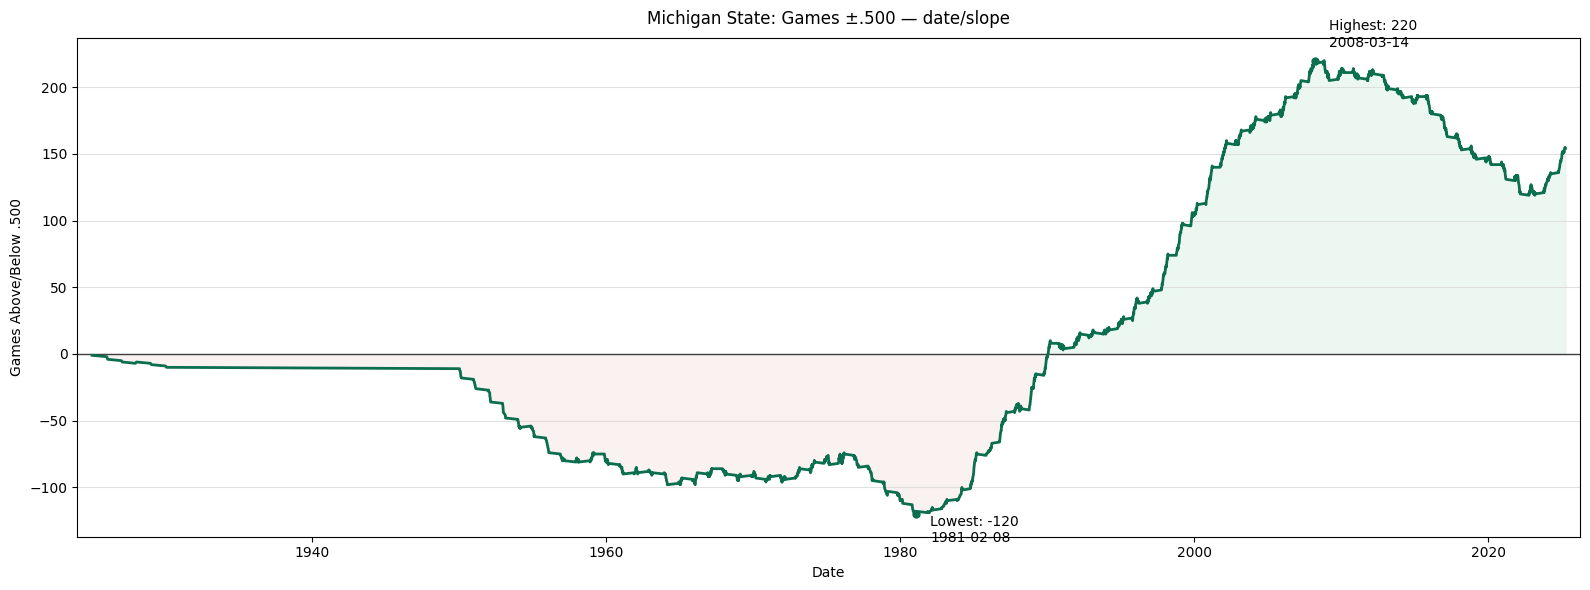

In [55]:
## Call Version 2 of Plotting Function
plot_team_timeline(tl, "Michigan State", mode="games",
                   time_scale="date", style="slope")

# plot_team_timeline(tl, "New Hampshire", mode="games",
                #    time_scale="games", style="slope", show_legend=True)
